## Name and ID

Ercan Sen (1226073)

## HW03 Code


You will complete the following notebook, as described in the PDF for Homework 03 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file and the two tree images (PDFs generated using `graphviz` within the code), to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.


Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2020/comp135).

### Import required libraries.

In [1]:
import os
import numpy as np
import pandas as pd

import warnings

from sklearn.linear_model import LogisticRegression as LogReg
import sklearn.tree
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import graphviz

## Part One: Cancer-Risk Screening

### 1.1: Compute true/false positives/negatives.

Complete the following code.

In [2]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    
    for i in range(ytrue_N.size):
        if ytrue_N[i] == 1: # TP or FN
            if yhat_N[i] == 1:
                TP += 1
            else:
                FN += 1
        else: # TN or FP
            if yhat_N[i] == 0:
                TN += 1
            else:
                FP += 1

    return TP, TN, FP, FN

In [3]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0.0, 0.0, 10.0, 0.0)

In [4]:
calc_TP_TN_FP_FN(all1, all0)

(0.0, 0.0, 0.0, 10.0)

In [5]:
calc_TP_TN_FP_FN(all1, all1)

(10.0, 0.0, 0.0, 0.0)

In [6]:
calc_TP_TN_FP_FN(all0, all0)

(0.0, 10.0, 0.0, 0.0)

### Supplied functions for later use

***Do not*** edit the following functions.  They are already complete, and will be used in your later code.

In [7]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [8]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [9]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: hist of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

### Load the dataset.

The following should ***not*** be modified.  After it runs, the various arrays it creates will contain the 2- or 3-feature input datasets.

In [10]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt('./data_cancer/x_train.csv', delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt('./data_cancer/x_valid.csv', delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt('./data_cancer/x_test.csv', delimiter=',', skiprows=1)

# 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [11]:
y_tr_M = np.loadtxt('./data_cancer/y_train.csv', delimiter=',', skiprows=1)
y_va_N = np.loadtxt('./data_cancer/y_valid.csv', delimiter=',', skiprows=1)
y_te_N = np.loadtxt('./data_cancer/y_test.csv', delimiter=',', skiprows=1)

### 1.2: Compute the fraction of patients with cancer.

Complete the following code.  Your solution needs to ***compute*** these values from the training, validation, and testing sets (i.e., don't simply hand-count and print the values).

In [12]:
print("Fraction with cancer in TRAIN: %.3f" % (y_tr_M.sum()/y_tr_M.size)) #TODO: modify what is printed here.
print("Fraction with cancer in VALID: %.3f" % (y_va_N.sum()/y_va_N.size))
print("Fraction with cancer in TEST : %.3f" % (y_te_N.sum()/y_te_N.size))

Fraction with cancer in TRAIN: 0.141
Fraction with cancer in VALID: 0.139
Fraction with cancer in TEST : 0.139


### 1.3: The predict-0-always baseline

#### (a) Compute the accuracy of the always-0 classifier.

Complete the code to compute and print the accuracy of the always-0 classifier on validation and test outputs.

In [13]:
print("Always-0: accuracy on VALID: %.3f" % ((y_va_N.size-y_va_N.sum())/y_va_N.size)) # TODO edit values!
print("Always-0: accuracy on TEST : %.3f" % ((y_te_N.size-y_te_N.sum())/y_te_N.size))

Always-0: accuracy on VALID: 0.861
Always-0: accuracy on TEST : 0.861


#### (b) Print a confusion matrix for the always-0 classifier.

Add code below to generate a confusion matrix for the always-0 classifier on the validation set.

In [14]:
print(calc_confusion_matrix_for_threshold(y_va_N, np.zeros(y_va_N.size), 1))

Predicted    0  1
True             
0          155  0
1           25  0


#### (c) Reflect on the accuracy of the always-0 classifier.

**Answer**: 86.1% accuracy of the always-0 classifier seems reasonably high at first sight. It is able to classify all the true negatives with no issue at all, and it never makes a false positive classification. Yet, if we focus on the rest of the story, we see that this classifier fails to detect all the cases where there actually is cancer, i.e. it makes only false negative clasifications and no true positive classifications.

#### (d) Analyze the various costs of using the always-0 classifier.


**Answer**: The task of this classification is determining cancer without biopsy, and even though the accuracy rate seems high, the classifier does a very poor job in its task as it fails to detect even a single case of cancer. The biggest cost of using the always-0 classifier is human lives. As we know that cancer is a highly pervasive disease, and if it goes untreated for a long time, there is a much higher chance that the patient won't survive. Given such high stakes, always-0 classifier should not be the choice in a task like this. We should also note that accuracy is not always a useful metric in measuring the performance of a model, since it contradicts with our conclusion. Another such exampe where accuracy metric gives a wrong impression is spam email detection: assume only 1% of the emails in an inbox is spam. If we again use an always-0 classifier and predict that none of the emails are spam, we would end up with a 99% accuracy metric, which is very high. However, since the whole point of such a clasifier is detecting spam, we would be doing a very poor job, even if the accuracy metric does not suggest so.

### 1.4: Logistic Regression

#### (a) Create a set of `LogisticRegression` models.

Each model will use a different control parameter, `C`, and each will be fit to 2-feature data.  Probabilistic predictions will be made on both training set and validation set inputs, and logistic-loss for each will be recorded.

In [15]:
tr_loss_list = list()
va_loss_list = list()

C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    logreg = LogReg(C=C, solver='liblinear')
    logreg.fit(x_tr_M2, y_tr_M)
    
    tr_proba = logreg.predict_proba(x_tr_M2)
    va_proba = logreg.predict_proba(x_va_N2)
    
    tr_loss_list.append(log_loss(y_tr_M, tr_proba))
    va_loss_list.append(log_loss(y_va_N, va_proba))

#### Plot logistic loss (y-axis) vs. C (x-axis) on the training set and validation set.

The best values for `C` and the loss should be printed.

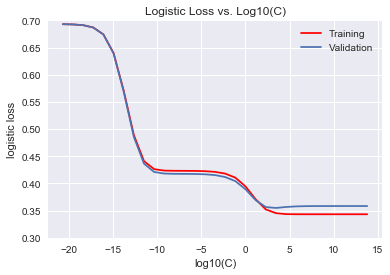

Best C-value for LR with 2-feature data: 31.623
Validation set log-loss at best C-value: 0.3549


In [16]:
# TODO make plot
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.3, 0.7]);
plt.plot(np.log(C_grid), tr_loss_list, c='red');
plt.plot(np.log(C_grid), va_loss_list);
plt.title('Logistic Loss vs. Log10(C)')

# TODO add legend
plt.legend(['Training', 'Validation']);

plt.show()

idx = np.argmin(va_loss_list)
print("Best C-value for LR with 2-feature data: %.3f" % C_grid[idx]) # TODO
print("Validation set log-loss at best C-value: %.4f" % va_loss_list[idx])

#### (b) Plot the performance of the predictions made by the best classifier from step (a) on the validation set.

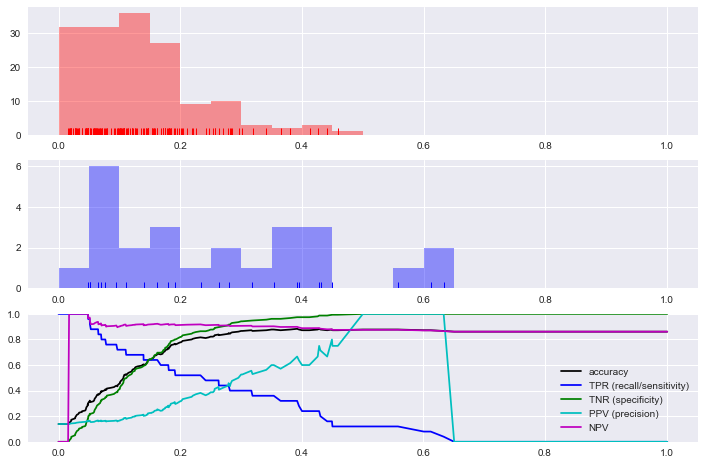

In [17]:
best = LogReg(C=C_grid[idx], solver='liblinear')
best.fit(x_tr_M2, y_tr_M)
best_proba = best.predict_proba(x_va_N2)
make_plot_perf_vs_threshold(y_va_N, best_proba[:,1])

#### (c) Model fitting with 3-feature data

Repeat the model generation from **1.4 (a)**, using the full 3-feature data.

In [18]:
tr_loss_list_3 = list()
va_loss_list_3 = list()

C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    logreg = LogReg(C=C, solver='liblinear')
    logreg.fit(x_tr_M3, y_tr_M)
    
    tr_proba_3 = logreg.predict_proba(x_tr_M3)
    va_proba_3 = logreg.predict_proba(x_va_N3)
    
    tr_loss_list_3.append(log_loss(y_tr_M, tr_proba_3))
    va_loss_list_3.append(log_loss(y_va_N, va_proba_3))

#### Plot logistic loss (y-axis) vs. C (x-axis) for the 3-feature classifiers on the training set and validation set.

Again, the best values for `C` and the loss should be printed.

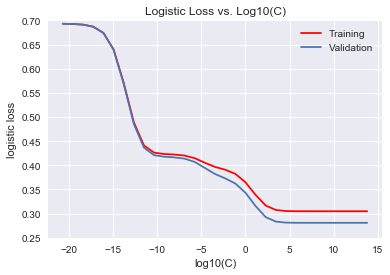

Best C-value for LR with 3-feature data: 1000000.000
Validation set log-loss at best C-value: 0.3584


In [19]:
# TODO make plot
plt.xlabel('log10(C)');
plt.ylabel('logistic loss');
plt.ylim([0.25, 0.7]);
plt.plot(np.log(C_grid), tr_loss_list_3, c='red');
plt.plot(np.log(C_grid), va_loss_list_3);
plt.title('Logistic Loss vs. Log10(C)')

# TODO add legend
plt.legend(['Training', 'Validation']);

plt.show()

idx3 = np.argmin(va_loss_list_3)
print("Best C-value for LR with 3-feature data: %.3f" % C_grid[idx3]) # TODO
print("Validation set log-loss at best C-value: %.4f" % va_loss_list[idx3])

#### Plot the performance of the predictions made by the best 3-valued classifier on the validation set.

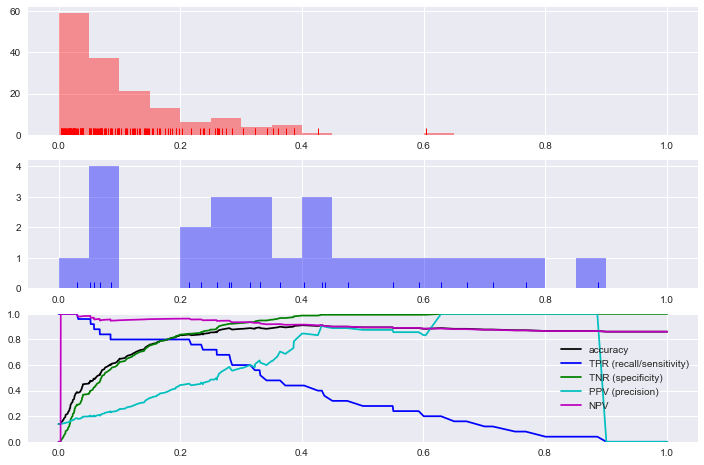

In [20]:
best3 = LogReg(C=C_grid[idx3], solver='liblinear')
best3.fit(x_tr_M3, y_tr_M)
best3_proba = best3.predict_proba(x_va_N3)
make_plot_perf_vs_threshold(y_va_N, best3_proba[:,1])

### 1.5: ROC Curves

These curves allow us to compare model performance in terms of trade-offs between false positive and true positive results.

#### (a) Plot ROC curves on the validation set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

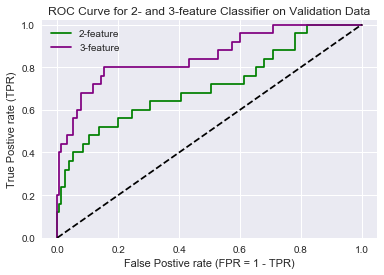

In [21]:
fpr_va_2, tpr_va_2, thr_va_2 = roc_curve(y_va_N, best_proba[:,1])
fpr_va_3, tpr_va_3, thr_va_3 = roc_curve(y_va_N, best3_proba[:,1])

plt.plot(fpr_va_2, tpr_va_2, c='green');
plt.plot(fpr_va_3, tpr_va_3, c='purple');
plt.plot([0,1],[0,1],c='black',linestyle='dashed')
plt.legend(['2-feature','3-feature'])
plt.ylim([0, 1.02]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");
plt.title('ROC Curve for 2- and 3-feature Classifier on Validation Data');

#### (b) Plot ROC curves on the test set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

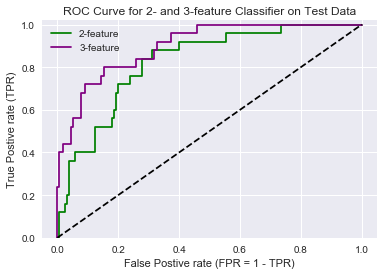

In [22]:
fpr_te_2, tpr_te_2, thr_te_2 = roc_curve(y_te_N, best.predict_proba(x_te_N2)[:,1])
fpr_te_3, tpr_te_3, thr_te_3 = roc_curve(y_te_N, best3.predict_proba(x_te_N3)[:,1])

plt.plot(fpr_te_2, tpr_te_2, c='green');
plt.plot(fpr_te_3, tpr_te_3, c='purple');
plt.plot([0,1],[0,1],c='black',linestyle='dashed')
plt.legend(['2-feature','3-feature'])
plt.ylim([0, 1.02]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");
plt.title('ROC Curve for 2- and 3-feature Classifier on Test Data');

#### (c) Analyze the results shown in both the above plots, to compare classifier performance.

**Answer**: We know that larger the area under the ROC curve, the better the model's performance. The dashed line on both graphs represent that the classification is made by random guess (so it is the worst possible way the model can possibly perform, and hence being further away from it translates into better performance--another way to interpret larger area under the curve). The ROCs for both validation and test sets show that the 3-feature classifier's performance is better. It implies that when we use the three features to build our model, the model predicts the true labels more accurately, compared to when we use the two features. Since including the additional feature ( _marker_ ) improved our model performance, we can conclude that the clinicians' belief that the measured chemical marker has some correlation with presence of cancer is true.

### 1.6: Selecting a decision threshold

#### (a) Using default 0.5 threshold. 

Generate a confusion matrix for the best 3-feature logistic model on the test set, using threshold 0.5.

In [23]:
best_thr = 0.5
best3_probs_1 = best3.predict_proba(x_te_N3)[:,1]

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, best3_probs_1, best_thr))
print("")
print_perf_metrics_for_threshold(y_te_N, best3_probs_1, best_thr)

ON THE VALIDATION SET:
Chosen best thr = 0.5000

ON THE TEST SET:
Predicted    0   1
True              
0          152   3
1           15  10

0.900 ACC
0.400 TPR
0.981 TNR
0.769 PPV
0.910 NPV


#### (b) Pick a threshold to maximize TPR, while ensuring PPV >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [24]:
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, best3_proba[:,1])

(inds,) = np.where(perf_grid['ppv']>=.98)
idx_tpr = np.argmax(np.array(perf_grid['tpr'][inds]))
idx_tpr = inds[idx_tpr]

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % thresh_grid[idx_tpr])
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, best3_probs_1, thresh_grid[idx_tpr]))
print("")
print_perf_metrics_for_threshold(y_te_N, best3_probs_1, thresh_grid[idx_tpr])

ON THE VALIDATION SET:
Chosen best thr = 0.6290

ON THE TEST SET:
Predicted    0  1
True             
0          155  0
1           20  5

0.889 ACC
0.200 TPR
1.000 TNR
1.000 PPV
0.886 NPV


#### (c) Pick a threshold to maximize PPV, while ensuring TPR >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [25]:
thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(y_va_N, best3_proba[:,1])

(inds,) = np.where(perf_grid['tpr']>=.98)
idx_ppv = np.argmax(np.array(perf_grid['ppv'][inds]))
idx_ppv = inds[idx_ppv]

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % thresh_grid[idx_ppv]) # TODO
print("")
print("ON THE TEST SET:")
print(calc_confusion_matrix_for_threshold(y_te_N, best3_probs_1, thresh_grid[idx_ppv]))
print("")
print_perf_metrics_for_threshold(y_te_N, best3_probs_1, thresh_grid[idx_ppv])

ON THE VALIDATION SET:
Chosen best thr = 0.0300

ON THE TEST SET:
Predicted   0   1
True             
0          57  98
1           0  25

0.456 ACC
1.000 TPR
0.368 TNR
0.203 PPV
1.000 NPV


#### (d) Compare the confusion matrices from (a)–(c) to analyze the different thresholds.

**Answer**: The resulting confusion matrices all demonstrate that there is no perfect threshold which will return the best values from every single performance metric. Since, as discussed earlier, the cost of a false negative classification in our case is human lives, our top goal is to avoid such classifications at all costs. To do that, we need to maximize TPR. Yet, while ensuring that first priority, we should also avoid unnecessary biopsies (i.e, false positives) as much as possible. To do that, we need a high value for PPV. Therefore, among the three thresholds that are examined, the third one that maximizes PPV, while ensuring TPR is at least 0.98, since that one suits the needs of the problem the best, as laid out hereby.

#### (e) How many biopsies can be avoided using the best threshold for the classifier?

**Answer**: 57 biopsies in the test set could have been avoided if this threshold was used, since 57 patients without cancer were predicted to be so by the classifier. Since there are 180 total patients in the test set, $57/180$ biopsies would have been saved, which is equal to 31.67%.

## Part Two: Decision Trees

You should start by computing the two heuristic values for the toy data described in the assignment handout. You should then load the two versions of the abalone data, compute the two heuristic values on features (for the simplified data), and then build decision trees for each set of data.

### 2.1 Compute both heuristics for toy data.

#### (a) Compute the counting-based heuristic, and order the features by it.

In [26]:
dict_A = {'True': {'circle':2, 'cross':0}, 'False': {'circle':2, 'cross':4} }
dict_B = {'True': {'circle':3, 'cross':1}, 'False': {'circle':1, 'cross':3} }

def guess_dict(Dict):
    for key in Dict:
        if Dict[key]['circle'] >= Dict[key]['cross']:
            Dict[key]['guess'] = 'circle'
        else:
            Dict[key]['guess'] = 'cross'

guess_dict(dict_A)
guess_dict(dict_B)

def compute_score(Dict):
    num_correct = 0
    num_total = 0
    for key in Dict:
        num_correct += Dict[key][Dict[key]['guess']]
        num_total += Dict[key]['circle']
        num_total += Dict[key]['cross']
    score = num_correct/num_total
    return score, num_correct, num_total

score_A, corr_A, total_A = compute_score(dict_A)
score_B, corr_B, total_B = compute_score(dict_B)

if score_A >= score_B:
    print('Feature A: ', corr_A, '/', total_A, sep='')
    print('Feature B: ', corr_B, '/', total_B, sep='')
else:
    print('Feature B: ', corr_B, '/', total_B, sep='')
    print('Feature A: ', corr_A, '/', total_A, sep='')

Feature A: 6/8
Feature B: 6/8


#### (b) Compute the information-theoretic heuristic, and order the features by it.

In [27]:
dict_All = {'circle': 4, 'cross': 4}
dict_A = {'True': {'circle':2, 'cross':0}, 'False': {'circle':2, 'cross':4} }
dict_B = {'True': {'circle':3, 'cross':1}, 'False': {'circle':1, 'cross':3} }

def Entropy(Dict):
    circle = Dict['circle']
    cross = Dict['cross']
    total = sum(Dict.values())
    if circle == 0:
        return -1*(cross/total*np.log2(cross/total))
    elif cross == 0:
        return -1*(circle/total*np.log2(circle/total))
    else:
        return -1*(circle/total*np.log2(circle/total) + cross/total*np.log2(cross/total))

def Gain(Dict, entropy_fullset):
    entr_Tr  = Entropy(Dict['True'])
    count_Tr = sum(Dict['True'].values())
    entr_Fa  = Entropy(Dict['False'])
    count_Fa = sum(Dict['False'].values())
    total = count_Tr + count_Fa
    
    return entropy_fullset - (count_Tr / total * entr_Tr + count_Fa / total * entr_Fa)


ent_All = Entropy(dict_All)

gain_A = Gain(dict_A, ent_All)
gain_B = Gain(dict_B, ent_All)

if gain_A >= gain_B:
    print('Feature A: %.3f' % gain_A)
    print('Feature B: %.3f' % gain_B)
else:
    print('Feature B: %.3f' % gain_B)
    print('Feature A: %.3f' % gain_A)

Feature A: 0.311
Feature B: 0.189


#### (c) Discussion of results.

The first heuristic is far too simple to be used for our model. Intuitively, we see that a good feature will divide the data into groups that are as homogenous as possible. In our example, separation by feature A results in one group that is fully homogenous; even so, the counting heuristic did not find a difference between the scores of feature A and feature B. In fact, there are many possible cases where there will be a tie because of the nature of this heuristic function. This is especially bad in the case of determining a feature for decision tree, because our aim is to find the superior feature among all and hence reduce the computational complexity as much as possible. On the other hand, information-theoretic heuristic gave results that confirm our intuition. Separation on feature A will result in an information gain of 0.311, while feature B has information gain 0.189. We can conclude that the second approach should be our method of choice for the heuristic.

### 2.2 Compute both heuristics for simplified abalone data.

#### (a) Compute the counting-based heuristic, and order the features by it.

In [28]:
X_tr_simple = pd.read_csv('data_abalone/small_binary_x_train.csv')
X_te_simple = pd.read_csv('data_abalone/small_binary_x_test.csv')
y_tr_simple = pd.read_csv('data_abalone/3class_y_train.csv')
y_te_simple = pd.read_csv('data_abalone/3class_y_test.csv')

X_tr_full = pd.read_csv('data_abalone/x_train.csv')
X_te_full = pd.read_csv('data_abalone/x_test.csv')
y_tr_full = pd.read_csv('data_abalone/y_train.csv')
y_te_full = pd.read_csv('data_abalone/y_test.csv')

features = []

for c in list(X_tr_simple.columns):
    var0_all_ys = y_tr_simple[X_tr_simple[c]==0]
    var1_all_ys = y_tr_simple[X_tr_simple[c]==1]
    
    var0_y0 = (var0_all_ys == 0).sum()['rings']
    var0_y1 = (var0_all_ys == 1).sum()['rings']
    var0_y2 = (var0_all_ys == 2).sum()['rings']
    
    var1_y0 = (var1_all_ys == 0).sum()['rings']
    var1_y1 = (var1_all_ys == 1).sum()['rings']
    var1_y2 = (var1_all_ys == 2).sum()['rings']
    
    numerator_c = max(var0_y0, var0_y1, var0_y2) + max(var1_y0, var1_y1, var1_y2)
    denominator_c = var0_y0 + var0_y1 + var0_y2 + var1_y0 + var1_y1 + var1_y2
    score_c = numerator_c / denominator_c
    
    features.append((c,score_c, numerator_c, denominator_c))

features.sort(key=lambda x: x[1], reverse=True)

for f in features:
    print(f[0], ': ', f[2], '/', f[3], sep='')

height_mm: 2316/3176
diam_mm: 2266/3176
length_mm: 2230/3176
is_male: 1864/3176


#### (b) Compute the information-theoretic heuristic, and order the features by it.

In [29]:
features_gain = []

def Entropy_aba(*args):
    total = 0
    for arg in args:
        total += arg
    entro = 0
    for arg in args:
        p_cat = arg / total
        entro += (p_cat * np.log2(p_cat))
    return -entro

entro_fullset = Entropy_aba((y_tr_simple == 0).sum()['rings'],(y_tr_simple == 1).sum()['rings'],(y_tr_simple == 2).sum()['rings'])

for c in list(X_tr_simple.columns):
    var0_all_ys = y_tr_simple[X_tr_simple[c]==0]
    var1_all_ys = y_tr_simple[X_tr_simple[c]==1]
    
    var0_y0 = (var0_all_ys == 0).sum()['rings']
    var0_y1 = (var0_all_ys == 1).sum()['rings']
    var0_y2 = (var0_all_ys == 2).sum()['rings']
    
    var1_y0 = (var1_all_ys == 0).sum()['rings']
    var1_y1 = (var1_all_ys == 1).sum()['rings']
    var1_y2 = (var1_all_ys == 2).sum()['rings']
    
    entro_0 = Entropy_aba(var0_y0, var0_y1, var0_y2)
    entro_1 = Entropy_aba(var1_y0, var1_y1, var1_y2)
    
    ratio_0 = var0_all_ys.size / y_tr_simple.size 
    ratio_1 = var1_all_ys.size / y_tr_simple.size
    
    gain = entro_fullset - (ratio_0 * entro_0 + ratio_1 * entro_1)
    
    features_gain.append((c, gain))
    
features_gain.sort(key=lambda x: x[1], reverse=True)

for f in features_gain:
    print(f[0], ': ', f[1], sep='')

height_mm: 0.17302867291002477
diam_mm: 0.1500706886802703
length_mm: 0.13543816377043694
is_male: 0.024516482271752293


### 2.3 Generate decision trees for full- and restricted-feature data

#### (a) Print accuracy values and generate tree images.

In [30]:
dec_full = sklearn.tree.DecisionTreeClassifier(criterion='entropy')
dec_full.fit(X_tr_full, y_tr_full)
tr_full_score = dec_full.score(X_tr_full, y_tr_full)
te_full_score = dec_full.score(X_te_full, y_te_full)

print('FULL DATA SET: ')
print('')
print('Accuracy Score on Training Set: %.4f' % tr_full_score)
print('Accuracy Score on Testing Set: %.4f' % te_full_score)
print('')

dec_simple = sklearn.tree.DecisionTreeClassifier(criterion='entropy')
dec_simple.fit(X_tr_simple, y_tr_simple)
tr_simple_score = dec_simple.score(X_tr_simple, y_tr_simple)
te_simple_score = dec_simple.score(X_te_simple, y_te_simple)

print('SIMPLIFIED DATA SET: ')
print('')
print('Accuracy Score on Training Set: %.4f' % tr_simple_score)
print('Accuracy Score on Testing Set: %.4f' % te_simple_score)
print('')

dec_full_data = sklearn.tree.export_graphviz(dec_full, out_file=None) 
graph_full = graphviz.Source(dec_full_data) 
graph_full.render("full");

dec_simple_data = sklearn.tree.export_graphviz(dec_simple, out_file=None) 
graph_simple = graphviz.Source(dec_simple_data) 
graph_simple.render("simple");

FULL DATA SET: 

Accuracy Score on Training Set: 1.0000
Accuracy Score on Testing Set: 0.1880

SIMPLIFIED DATA SET: 

Accuracy Score on Training Set: 0.7327
Accuracy Score on Testing Set: 0.7220



#### (b) Discuss the results seen for the two trees

The results show that the using the full data set with all the features result in overfitting. We can make that conclusion based on the accuracy score of 100% on the training set, while a very poor score of 18.8% on the testing set. The tree of this model also supports this claim, since it is huge and has so many branches: it implies that it would not be so good at generalizing to other cases.

On the other hand, the model that was trained with the simplified version of the dataset does a better job. It has accuracy scores of 73.27% and 72.2% on Training and Testing sets, respectively, which are not bad (at least good enough not to overfit). The tree has a more reasonable size with only 4 levels.  